#  trail run estimate

at the trail, it is especially important to correctly asses duration of the activitity, since it is a safety factor.

the goal here is to asses correctly the trail run time, point out potentially too steep regions, snow conditions, need for light, view points

time of walk and of run

faster run or walk

TODO: add webhook
https://developers.strava.com/docs/webhooks/

TODO: make async


import by gpx url

In [5]:
import numpy as np
from matplotlib import cm

fractions=[0,0.5, 1]
i=0

tuple((int, 255*np.array(cm.jet(i/len(fractions))[:-1])))

#logging.basicConfig(level=logging.DEBUG)

from importlib import reload  # Not needed in Python 2
import logging
reload(logging)

logger = logging.getLogger()
logger.setLevel(logging.INFO)


import matplotlib as mpl
from matplotlib import pylab as plt
from matplotlib import cm as cm
import numpy as np
import requests
import time
from IPython.display import display, HTML
from urllib.parse import urlencode
import yaml

# model

power modes: fixed VAM (power to potential), fixed speed (power to running frix)

# TODO

find walk regions by cadence
run and walk by grade, metrc

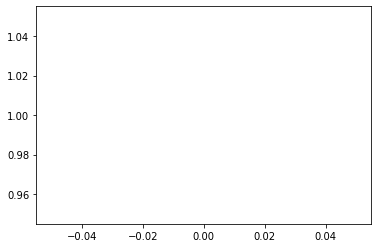

In [6]:
plt.plot([1])

In [7]:
c = yaml.safe_load(open("strava-client.yaml"))

client_id = c['client_id']
client_secret = c['client_secret']

In [8]:
# auth?

print("http://www.strava.com/oauth/authorize?" + urlencode(dict(
        client_id=client_id,
        response_type="code",
        redirect_uri="http://localhost/exchange_token",
        #redirect_uri="http://trail.volodymyrsavchenko.com:8000/exchange_token",
        approval_prompt="force",
        scope="activity:read_all",
    )))

code=input()

r=requests.post("https://www.strava.com/api/v3/oauth/token",
  data=dict(
      client_id=client_id,
      client_secret=client_secret,
      code=code,
      grant_type="authorization_code",
  )
).json()

token=r['access_token']

http://www.strava.com/oauth/authorize?client_id=58682&response_type=code&redirect_uri=http%3A%2F%2Flocalhost%2Fexchange_token&approval_prompt=force&scope=activity%3Aread_all


In [9]:
try:
    #token = open('strava-token').read()
    raise
except:
    token=r['access_token']

    with open('strava-token', 'w') as f:
        f.write(token)

In [10]:
requests.get("https://www.strava.com/api/v3/athlete", headers={"Authorization": f"Bearer {token}"}).json()

{'id': 31879825,
 'username': None,
 'resource_state': 2,
 'firstname': 'Volodymyr',
 'lastname': 'Savchenko',
 'bio': None,
 'city': 'Zürich',
 'state': 'Zürich',
 'country': 'Switzerland',
 'sex': 'M',
 'premium': True,
 'summit': True,
 'created_at': '2018-06-16T19:52:50Z',
 'updated_at': '2021-12-24T08:35:31Z',
 'badge_type_id': 1,
 'weight': 73.0,
 'profile_medium': 'https://lh3.googleusercontent.com/a-/AAuE7mBeCQwB47Prrxvs5fOObJZ933AFZvWnaVPnl8HQug',
 'profile': 'https://lh3.googleusercontent.com/a-/AAuE7mBeCQwB47Prrxvs5fOObJZ933AFZvWnaVPnl8HQug',
 'friend': None,
 'follower': None}

In [11]:
import time
import bravado
import bravado.client
import bravado.requests_client
import bravado.http_client

reload(bravado), reload(bravado.client), reload(bravado.requests_client), reload(bravado.http_client)

from bravado.requests_client import RequestsClient
from bravado.client import SwaggerClient

http_client = RequestsClient()
http_client.set_api_key(
    'www.strava.com', 'Bearer '+token,
    param_name='Authorization', param_in='header'
)

client = SwaggerClient.from_url(
    'https://developers.strava.com/swagger/swagger.json',
    http_client=http_client,
    config={
        'validate_swagger_spec': False,
        'validate_responses': False,
        'validate_requests': False,
    },
)
athlete = client.Athletes.getLoggedInAthlete().response().result
athlete

{'id': 31879825,
 'username': None,
 'resource_state': 2,
 'firstname': 'Volodymyr',
 'lastname': 'Savchenko',
 'bio': None,
 'city': 'Zürich',
 'state': 'Zürich',
 'country': 'Switzerland',
 'sex': 'M',
 'premium': True,
 'summit': True,
 'created_at': datetime.datetime(2018, 6, 16, 19, 52, 50, tzinfo=tzutc()),
 'updated_at': datetime.datetime(2021, 12, 24, 8, 35, 31, tzinfo=tzutc()),
 'badge_type_id': 1,
 'weight': 73.0,
 'profile_medium': 'https://lh3.googleusercontent.com/a-/AAuE7mBeCQwB47Prrxvs5fOObJZ933AFZvWnaVPnl8HQug',
 'profile': 'https://lh3.googleusercontent.com/a-/AAuE7mBeCQwB47Prrxvs5fOObJZ933AFZvWnaVPnl8HQug',
 'friend': None,
 'follower': None,
 'follower_count': None,
 'friend_count': None,
 'measurement_preference': None,
 'ftp': None,
 'clubs': None,
 'bikes': None,
 'shoes': None}

In [12]:
routes = requests.get(f"https://www.strava.com/api/v3/athletes/{athlete['id']}/routes", 
                              params=dict(
                                  per_page=100
                              ),
                              headers={'Authorization': 'Bearer '+token}
                             ).json()

In [13]:
import io
import gpxpy


for route in routes:
    print("getting route gpx for", route['id'])
    route['route_gpx'] = gpxpy.parse(io.BytesIO(requests.get(f"https://www.strava.com/api/v3//routes/{route['id']}/export_gpx", 
                                  params=dict(
                                      per_page=100
                                  ),
                                  headers={'Authorization': 'Bearer '+token}
                                 ).content))
    route['route_points'] = route['route_gpx'].tracks[0].segments[0].points

    print("got", route['route_gpx'].tracks[0])
    break

getting route gpx for 2905931787406365890
got GPXTrack(name='Verbier Marathon 4000', segments=[GPXTrackSegment(points=[...])])


In [14]:
for route in routes:
    #if '21' not in route['route_gpx'].name: continue
    #if 'par KV' not in route['route_gpx'].name: continue
    
    print(f"\033[31m{route['route_gpx'].name}\033[0m", route['type'], route['sub_type'], route['distance']/1000.)


Verbier Marathon 4000 2 4 44.57153611690321


KeyError: 'route_gpx'

In [15]:
route['distance'], route['elevation_gain']

import sys
import os

os.environ['FLASK_SECRET_KEY'] = "x"
sys.path.insert(0, 'app')
from trailsapp.analyze import speed_estim_for_grade, d_

In [19]:
if False:
    activities = client.Activities.getLoggedInAthleteActivities(
        after=int(time.time() - 720*24*3600),
        perPage=100,
    ).response().result
else:
    activities = requests.get("https://www.strava.com/api/v3/athlete/activities", 
                              params=dict(
                                  per_page=200,
                                  page=1,
                              ),
                              headers={'Authorization': 'Bearer '+token}
                             ).json()

In [20]:
for activity in activities:
    if 'Ride' in activity['name'] or activity['total_elevation_gain'] < 300:
        activity.pop('streams', None)
        continue
        
        
    
    activity['streams'] = client.Streams.getActivityStreams(
        id=activity['id'], 
        keys="time, distance, latlng, altitude, velocity_smooth, heartrate, cadence, watts, temp, moving, grade_smooth".split(", "),
        key_by_type=True,
    ).response().result


    
    print(activity['name'])

Lunch 
Morning Run
Lunch Walk
Afternoon 
Morning Run
Engelberg to Stans attempt
Region reconaissance, Wildgärst
Afternoon Run
Afternoon Hike
MXSKY
Lunch Run
Morning
Morning
Lunch
Morning
Morning Run
Lunch Run
Lunch Run
Slightly more successful attempt to trail run than https://www.strava.com/activities/5027079530


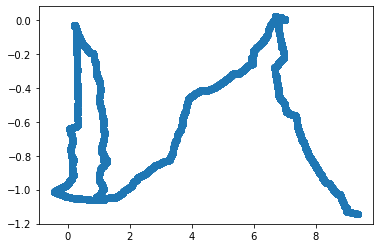

In [236]:
for activity in activities:
    if 'streams' not in activity: continue
    if 'Ride' in activity['name']: continue

    if 'Slightly' in activity['name']: break
    # if activity.get('total_photo_count') > 0:
    #     print(f"{activity['total_photo_count']:5d} {activity['name']}")
    #     break
    

# act = client.Activities.getActivityById(
#         id=activity['id']).response()

lat, lng = np.array(activity['streams']['latlng']['data']).transpose()
alt = np.array(activity['streams']['altitude']['data'])/1000.

R0_km = 6357
R_m =  R0 + alt

# Z = R_m * np.sin(lat/180*np.pi)
# X = R_m * np.cos(lat/180*np.pi)*np.sin(lng/180*np.pi)
# Y = R_m * np.cos(lat/180*np.pi)*np.cos(lng/180*np.pi)

wildspitz_lnglat = 47.0805131,8.5629319

x = (wildspitz_lnglat[1] - lng)/180*np.pi*R0_km*np.cos(lat/180*np.pi)
y = (wildspitz_lnglat[0] - lat)/180*np.pi*R0_km
z = (alt - 1.580)

#a = x
#b = y

v_n = np.array((1, 0, 0))

off_n = np.dot(v_n, [x, y, z])


if False:
    fig = plt.figure(figsize=(10,10))

    ax = fig.add_subplot(projection='3d')


    ax.scatter(
            x, y, z
        )

    ax.plot(
            [0,0,0],
            view,
            c='r'
        )
    #ax.scatter(*, c='r')

    ax.view_init(90, 90)

plt.figure()

plt.scatter(off_n, z)

(-2.5, 2.5)

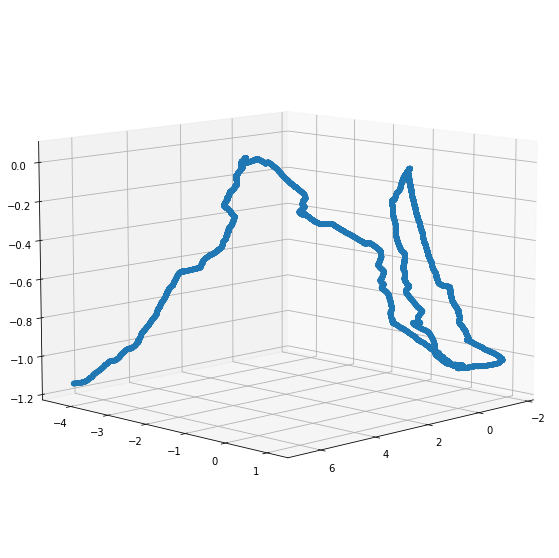

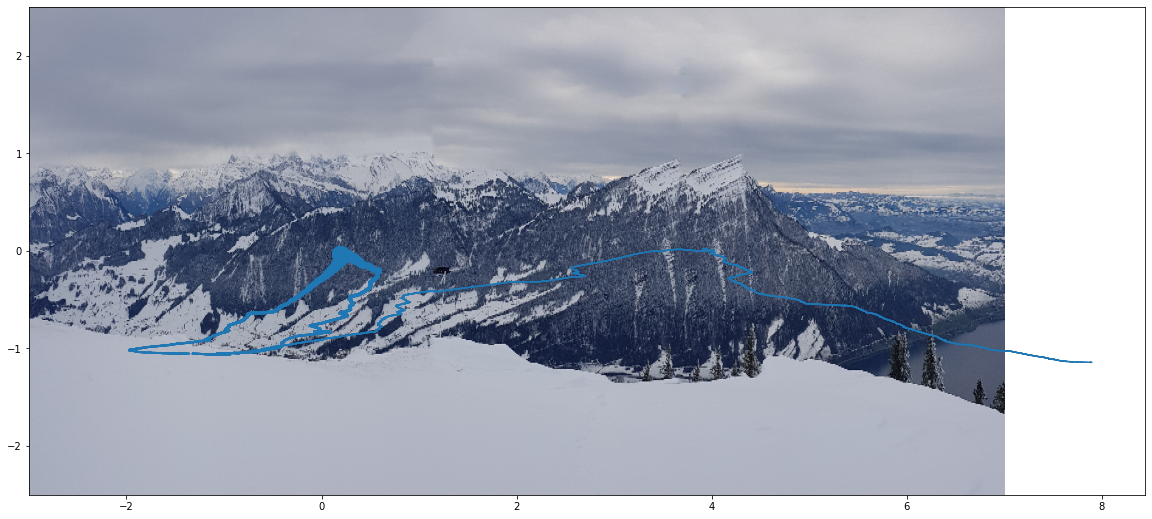

In [325]:
r = np.array([x, y, z])

v_n = np.array([(10,15,0)])
v_n = v_n / (v_n**2).sum()**0.5

v_a = np.array([(0,0,1)]) # todo perp to v_n
v_b = np.cross(v_a, v_n)


r_on_v_n = np.dot(v_n, r)/np.sum(v_n**2)**0.5

r_off_v_n = r - np.outer(v_n, np.ones(r_on_v_n.shape[0]))*r_on_v_n

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(*r_off_v_n)

ax.view_init(10, 45)

r_n = r / np.sum(r**2, 0)**0.5

#np.dot(v_n, r_n)[:5], r_on_v_n[0,:5], r_n[0,:5], r_off_v_n[0,:5]

plt.figure(figsize=(20,20))
a = np.dot(v_a, r_off_v_n)
b = np.dot(v_b, r_off_v_n)

from PIL import Image
img = Image.open(os.getenv('HOME') + '/Downloads/20211212_140057.jpg')
img = np.asarray(img)

plt.imshow(
    img[::5,::5,:],
    extent=(-3, 7, -5, 5)
    )


plt.scatter(
    -b, a,
    s=1/(r**2).sum(0)*10
)

#plt.xlim([-10,10])
plt.ylim([-2.5,2.5])

# r_off_v_n

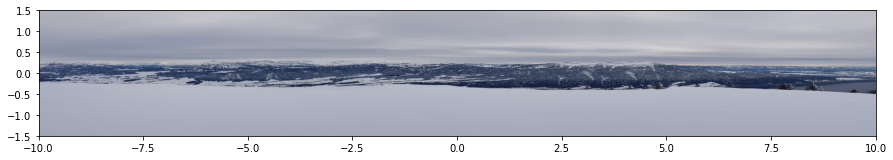

In [298]:
from PIL import Image
img = Image.open(os.getenv('HOME') + '/Downloads/20211212_140057.jpg')
img = np.asarray(img)

plt.figure(figsize=(15,10))
plt.imshow(
    img[::5,::5,:],
    extent=(-10,10, -1.5, 1.5)
    )


In [254]:
# import io
# from exif import Image

# # img_url = act.result['photos']['primary']['urls']['600']
# # img_url = "https://dgtzuqphqg23d.cloudfront.net/9lioRfX8-JTmpw56cbonbrOyNGubE6sGC8T7DR6hW6w-2048x1204.jpg"
# #img = Image(io.BytesIO(requests.get(img_url).content))
# img = Image(open(os.getenv('HOME') + '/Downloads/20211212_140057.jpg', 'rb'))

In [25]:
assert img.has_exif

img.get_all()

{'image_width': 3854939288,
 'image_height': 3854939284,
 'make': 'samsung',
 'model': 'SM-G950F',
 'orientation': <Orientation.TOP_LEFT: 1>,
 'x_resolution': 72.0,
 'y_resolution': 72.0,
 'resolution_unit': <ResolutionUnit.INCHES: 2>,
 'software': 'G950FXXUCDUD1',
 'datetime': '2021:12:12 14:00:56',
 'y_and_c_positioning': 1,
 '_exif_ifd_pointer': 226,
 'f_number': 1.7,
 'exposure_program': <ExposureProgram.NORMAL_PROGRAM: 2>,
 'exif_version': '0220',
 'datetime_original': '2021:12:12 14:00:56',
 'datetime_digitized': '2021:12:12 14:00:56',
 'max_aperture_value': 1.53,
 'metering_mode': <MeteringMode.AVERAGE: 1>,
 'flash': Flash(flash_fired=False, flash_return=FlashReturn.NO_STROBE_RETURN_DETECTION_FUNCTION, flash_mode=FlashMode.COMPULSORY_FLASH_SUPPRESSION, flash_function_not_present=False, red_eye_reduction_supported=False, reserved=0),
 'focal_length': 4.2,
 'color_space': <ColorSpace.SRGB: 1>,
 'pixel_x_dimension': 3854939288,
 'pixel_y_dimension': 3854939284,
 'exposure_mode': <E

In [55]:
lut_merged = None

len(activities)

200

/tmp/ipykernel_2804661/2934076768.py:29: RuntimeWarning: invalid value encountered in true_divide
  speed_kph = d_d3/d_time *3600./1000.
/tmp/ipykernel_2804661/2934076768.py:30: RuntimeWarning: invalid value encountered in true_divide
  vam = d_altitude/d_time
/tmp/ipykernel_2804661/2934076768.py:31: RuntimeWarning: invalid value encountered in true_divide
  grade = d_altitude/d_d3*100.
/tmp/ipykernel_2804661/2934076768.py:43: RuntimeWarning: invalid value encountered in true_divide
  speed_kph = d_d3/d_time *3600./1000.
/tmp/ipykernel_2804661/2934076768.py:44: RuntimeWarning: divide by zero encountered in true_divide
  vam = d_altitude/d_time*1000
/tmp/ipykernel_2804661/2934076768.py:45: RuntimeWarning: divide by zero encountered in true_divide
  grade = d_altitude/d_d3*100.


found step 30.0
found step 0.2
found step 0.1
total time 3.9033333333333333 hr
found step 38.0
found step 0.2
found step 0.7
total time 2.4894444444444446 hr
found step 32.0
found step 0.2
found step 0.1
total time 3.0861111111111112 hr
found step 80.0
found step 0.2
found step 1.4
total time 0.46 hr
found step 32.0
found step 0.2
found step 0.2
total time 3.2605555555555554 hr
found step 28.0
found step 0.2
found step 0.2
total time 6.806388888888889 hr
found step 30.0
found step 0.2
found step 0.1
total time 3.410833333333333 hr
found step 32.0
found step 0.1
found step 0.2
total time 2.7575 hr
found step 80.0
found step 0.2
found step 0.6
total time 0.7413888888888889 hr
found step 28.0
found step 0.2
found step 0.2
total time 6.577222222222222 hr
found step 30.0
found step 0.2
found step 0.1
total time 5.328888888888889 hr
found step 28.0
found step 0.2
found step 0.1
total time 6.84 hr
found step 30.0
found step 0.2
found step 0.1
total time 7.1433333333333335 hr
found step 30.0
f

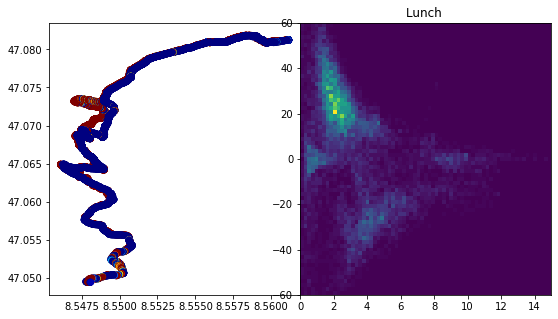

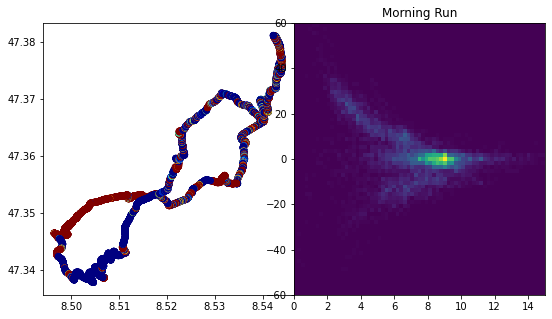

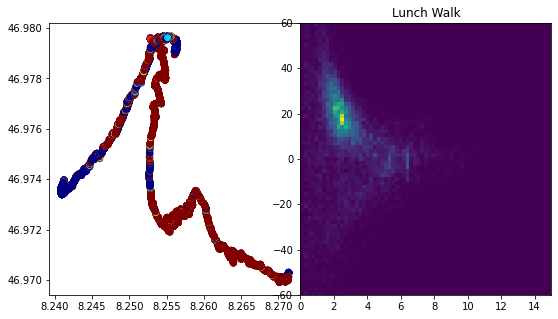

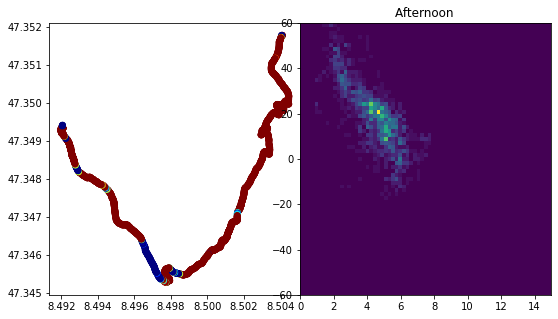

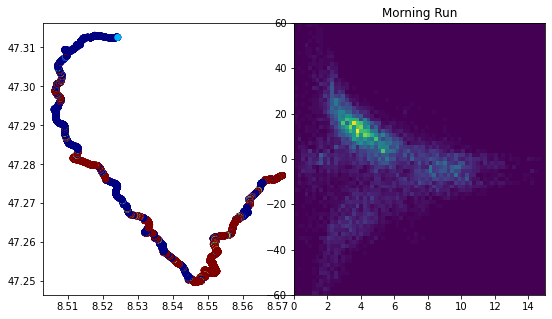

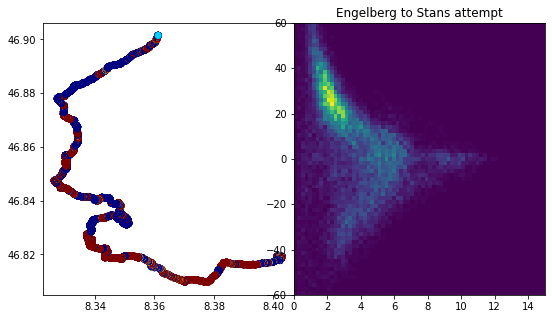

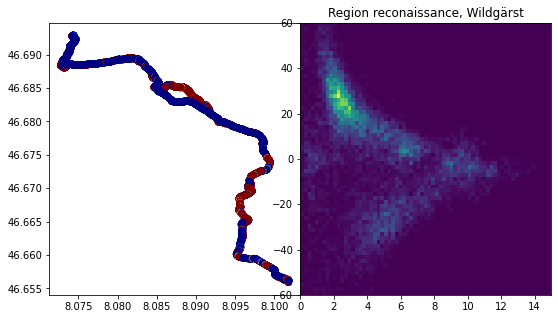

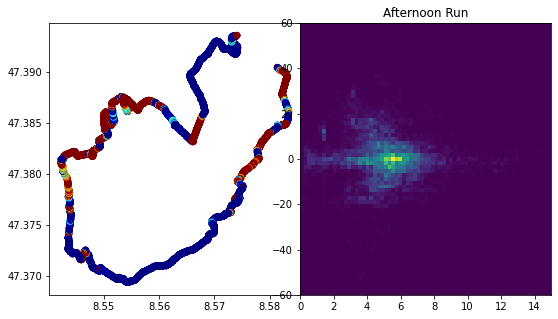

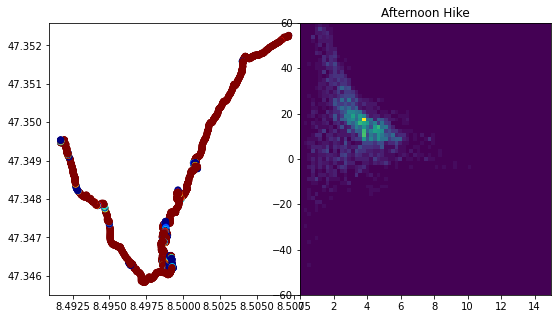

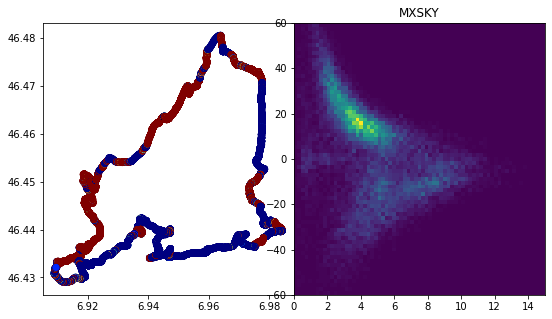

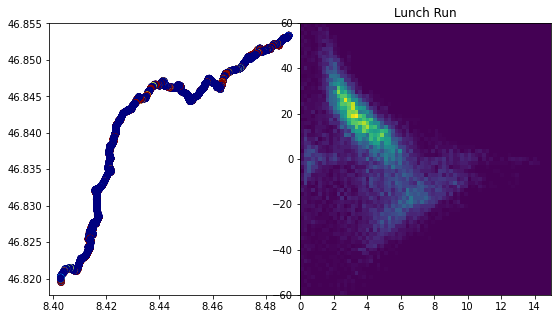

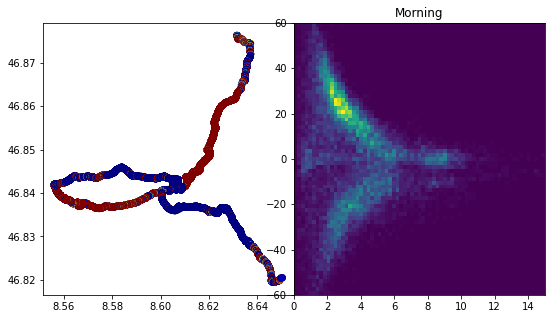

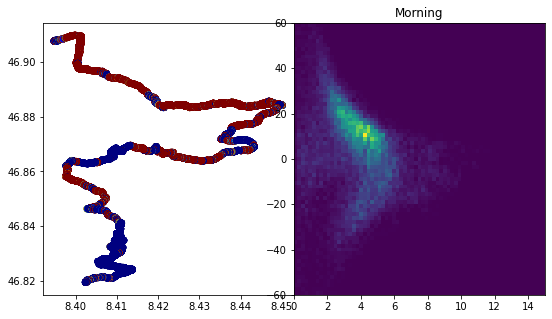

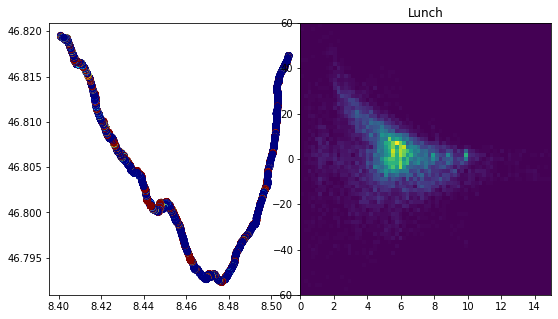

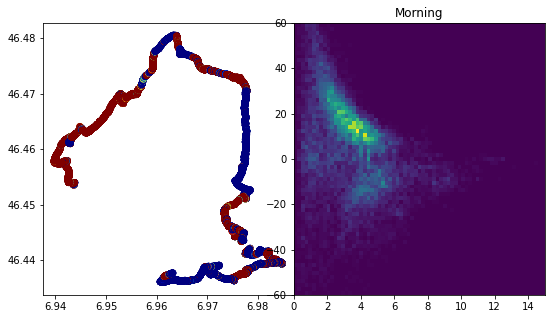

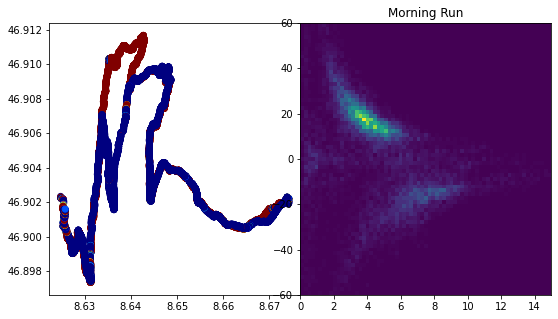

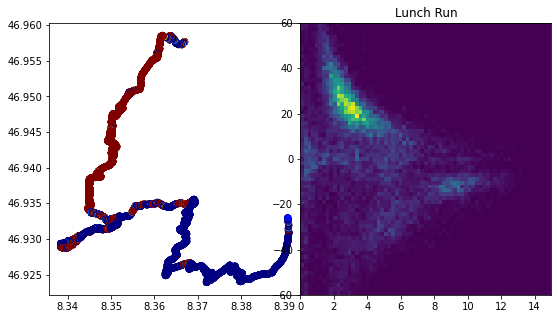

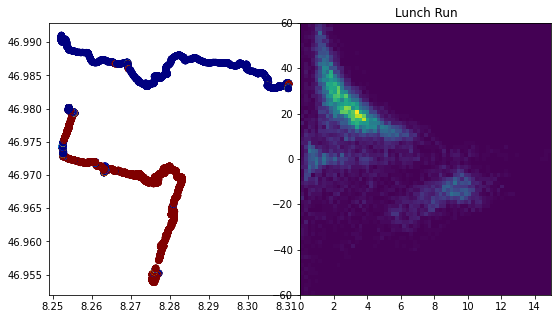

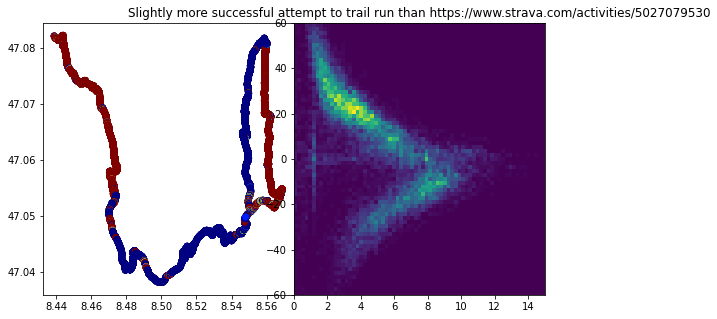

In [56]:
#plt.figure()

d_N = 10

luts = []

for activity in activities:
    if 'streams' not in activity: continue
        
    #if 'Lake Winter' not in activity['name']: continue
        
    streams = activity['streams']
    
    
    distance = np.array(streams['distance']['data'])
    altitude = np.array(streams['altitude']['data'])
    ttime = np.array(streams['time']['data'])
    latlng = np.array(streams['latlng']['data'])
    cadence = np.array(streams['cadence']['data'])*2.
    heartrate = np.array(streams['heartrate']['data'])
  
    
    d_distance1 = d_(distance, 1)
    d_distance = d_(distance, d_N)
    d_altitude = d_(altitude, d_N)
    d_d3 = (d_distance**2 + d_altitude**2)**0.5
    d_time = d_(ttime, d_N)
    
    speed_kph = d_d3/d_time *3600./1000.
    vam = d_altitude/d_time    
    grade = d_altitude/d_d3*100.
    

    def dealias(x):
        mn = np.round(np.abs(x[x>0]).min(), 5)
        print("found step", mn)
        x += np.random.rand(altitude.shape[0])*mn - mn/2.
        
    dealias(cadence)
    dealias(d_altitude)
    dealias(d_distance)

    speed_kph = d_d3/d_time *3600./1000.
    vam = d_altitude/d_time*1000
    grade = d_altitude/d_d3*100.

    m = np.abs(d_altitude)<1000
    m &= np.abs(vam)<2000

    def p2d(x,y, x_bins, y_bins, mode='hist'):

        if mode == "scatter":
            plt.scatter(x,y,s=5)
        elif mode == 'hist':
            return plt.hist2d(x,y, bins=(
                    x_bins,
                    y_bins,
                )
            )
        elif mode == 'contour':
            h2, a,b  = np.histogram2d(x,y, bins=(
                    x_bins,
                    y_bins,
                )
            )

            plt.contourf(
                a[:-1],
                b[:-1],
                np.transpose(h2),
                #levels=np.logspace(np.log10(h2.max()/1000.), np.log10(h2.max()), 100)
                levels=np.linspace(0, h2.max(), 100)
            )


    for mode in 'hist',: #'contour':
        f, (ax1,ax2)= plt.subplots(1,2,figsize=(9,5))
        lut_speed_grade = p2d(
            speed_kph[m],
            #d_altitude[m]/d_time[m]*3600.,
            #60./(d_distance[m]/d_time[m]*3600./1000.),
            #d_distance[m]/d_time[m]*3600./1000.,
            #d_altitude[m]/d_time[m]*3600.,
            #d_altitude[m]/d_time[m]*3600,
            grade[m],
            mode = mode,
            x_bins = np.linspace(0, 15, 70),
            y_bins = np.linspace(-60, 60, 70),
            #y_bins = np.linspace(-2000, 2000, 70),
        )
        
        luts.append(lut_speed_grade)
        
        plt.subplots_adjust(wspace=0)
        
        ax1.scatter(latlng[:,1], latlng[:,0], 
            #c=cm.jet(np.array(streams['velocity_smooth']['data'])/6.),
            c=cm.jet((
                np.array(d_altitude*3600)/(1000.)
                #np.array(streams['altitude']['data'])-320)/(600-320)
            ),
        ))
        
        plt.title(activity['name'])
        
    print("total time", (ttime[-1] - ttime[0])/3600., "hr")
    
    if lut_merged is None:
        continue

    x_grade = np.linspace(-50,50)
    ax2.plot(
        [speed_estim_for_grade(x, lut_merged, (0, 1.)) for x in x_grade],
        x_grade,
        c="k",
        lw=3,
    )
    ax2.plot(
        [speed_estim_for_grade(x, lut_merged, (0.3, 0.7)) for x in x_grade],
        x_grade,
        c="r",
        lw=3,
        ls=":"
    )
    
    plt.figure()
    plt.hist2d(
        grade[m], 
        heartrate[m],
        bins=(100, 100),
    )
    plt.axvline(8.)
    

    
    total_time_estim = 0
    sum_time = 0
    i = 0
    for d_d, d_a, d_t, _t in zip(d_d3, d_altitude, d_time, ttime):
        i += 1
        if i<30: continue
        if i>len(d_time)-100: continue
        
        #print(d_d, d_a)
        
        grade = d_a/d_d*100.
        
        d_time_estim = d_d/(speed_estim_for_grade(grade, lut_merged)/3600.*1000)/(d_N-1)
        
        if not np.isnan(d_time_estim)and  not np.isinf(d_time_estim):
            total_time_estim += d_time_estim
            sum_time += d_t/(d_N-1)
                        
        #print("since", _t - ttime[0], "estim", total_time_estim, "sum", sum_time)
        #print("grade", grade, "speed", d_d/d_t*3.6, "estim speed", speed_estim_for_grade(grade, lut_speed_grade), "time estim", d_time_estim, "time spent", d_t)
        
        
        
    print("total time estimate", total_time_estim/3600., "hr", "summed time", sum_time/3600., "hr")
    
    print("total run fraction", np.sum(m_run)/m_run.shape[0])
        
    #break

    #ax=plt.gca()
    #ax2=plt.twiny()
    #ax2.set_xlim(60./np.array(ax.get_xlim()))

    #plt.xlabel("pace")
    #plt.ylabel("grade")
    #plt.ylabel("VAM")

/home/savchenk/.pyenv/versions/3.9.6/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


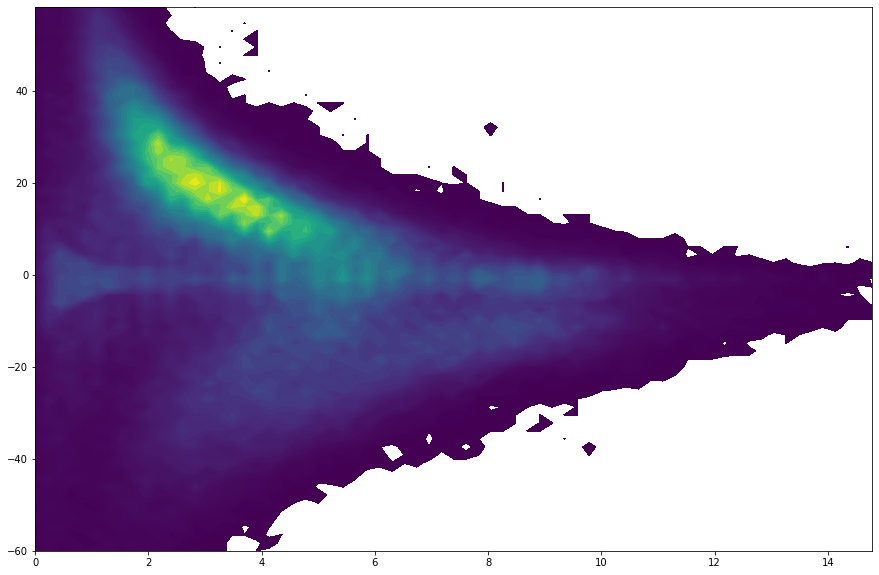

In [57]:
lut_merged = np.sum([l[0] for l in luts], 0), luts[0][1], luts[0][2]

np.save(open("lut_merged.npy", "wb"), lut_merged)

plt.figure(figsize=(15,10))

plt.contourf(
    lut_merged[1][:-1],
    lut_merged[2][:-1],
    lut_merged[0].transpose()/lut_merged[0].max(),
    np.logspace(-3,0,100)
    )

Verbier Marathon 4000 2 4


/tmp/ipykernel_2827284/3059849928.py:18: RuntimeWarning: invalid value encountered in true_divide
  route_grade = d_(route_altitude)/d_(route_d3, 10)*100.


NameError: name 'lut_merged' is not defined

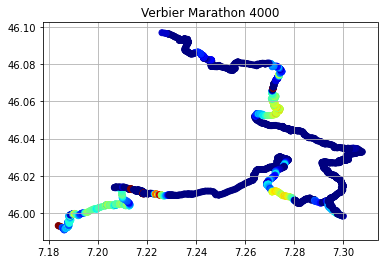

In [17]:


d_N = 2
N = 3

for route in routes:
    #if '21' not in route['route_gpx'].name: continue
    #if 'KV' not in route['route_gpx'].name: continue
    if 'Verb' not in route['route_gpx'].name: continue
    #if 'route_gpx'
    
    route_points = route['route_points']

    d_route_d3 = np.array([0] + [a.distance_3d(b) for a,b in zip(route_points[:-1], route_points[1:])])
    route_d3 = np.cumsum(d_route_d3)

    route_lat = np.array([p.latitude for p in route_points])
    route_lon = np.array([p.longitude for p in route_points])
    route_altitude = np.array([p.elevation for p in route_points])
    route_grade = d_(route_altitude)/d_(route_d3, 10)*100.

    plt.figure()
    plt.title(route['route_gpx'].name)
    print(f"\033[31m{route['route_gpx'].name}\033[0m", route['type'], route['sub_type'])

    plt.scatter(
        route_lon,
        route_lat,
        c=cm.jet(route_grade/50.),
    )

    plt.grid()
    #plt.ylim([-50, 50])

    total_time_estim = 0
    i = 0
    d_time_estims = []
    for d_d, d_a in zip(d_route_d3, d_(route_altitude, 2)):
        d_time_estims.append(0)
        
        i += 1
        if i<d_N +1: continue
        if i>len(route_d3)-d_N -1: continue

        grade = d_a/d_d*100.

        estim_speed_ms = (speed_estim_for_grade(grade, lut_merged)/3600.*1000)
        d_time_estim = d_d/(estim_speed_ms)/(d_N-1)

        if not np.isnan(d_time_estim) and not np.isinf(d_time_estim):
            total_time_estim += d_time_estim
            #sum_time += d_t/(d_N-1)
            d_time_estims[-1] = d_time_estim

        #print("since", _t - ttime[0], "estim", total_time_estim, "sum", sum_time)
        #print(f"dd {d_d:.2f} {d_a:.2f} grade {grade:.2f} estim speed {estim_speed_ms*3.6:.2f}, dtime {d_time_estim:.3f} total time {total_time_estim/3600.:.2f}")

    d_time_estims=np.array(d_time_estims)
    
    print(f"total distance {np.sum(d_route_d3)/1000.:.2f} km (strava {route['distance']/1000.:.2f})")
    
    asc = d_(route_altitude, 2)
    
    print(f"cumulative elevation gain {np.sum(np.sum(d_(route_altitude, N)/(N-1))):.2f} m (strava {route['elevation_gain']:.2f})")
    print(f"total elevation gain {np.sum(asc[asc>0]):.2f} m (strava {route['elevation_gain']:.2f})")
    print(f"total time {total_time_estim/3600.:.2f} strava estim {route['estimated_moving_time']/3600.:.2f}")
    m_route_run_steep = route_grade<-20.
    m_route_run_flat = (route_grade<8.) & (route_grade>-20.)
    m_route_walk = route_grade>8.
    m_route_steep = route_grade>30.

    for n, mx in [
        ("down steep", m_route_run_steep),
        ("run flat", m_route_run_flat),
        ("walk up", m_route_walk),
        ("steep up", m_route_steep),
    ]:        
        print(f"{n:10s} "+
              f"\033[032m{np.sum(d_time_estims[mx])/np.sum(d_time_estims)*100:5.1f}%\033[0m time " +
              f"{np.sum(d_time_estims[mx])/3600.:.2f} hr " +
              f"{np.sum(d_route_d3[mx])/1000.:.2f} km",
              f"{np.sum(d_(route_altitude, N)[mx])/(N-1):.2f} VAM",
             )
        
        
    if False:
        plt.figure()
        plt.plot(
            np.cumsum(d_route_d3),
            route_altitude,
        )
        plt.plot(
            np.cumsum(d_route_d3),
            np.cumsum(d_(route_altitude, N))/(N-1),
        )
        plt.grid()
        
    #break
    
    
    


In [35]:
# plt.figure()
# _ = plt.hist(np.array(cadence)*2, 100)

Text(0.5, 0, 'VAM')

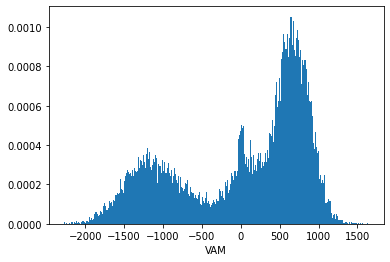

In [59]:
plt.figure()

_=plt.hist(d_altitude[m]/d_time[m]*3600, 300, density=True)
plt.xlabel('VAM')